In [9]:
from functools import partial

import jax
import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import trange

## The dataset

We'll use two moons to keep things simple.

(-2.0, 2.0)

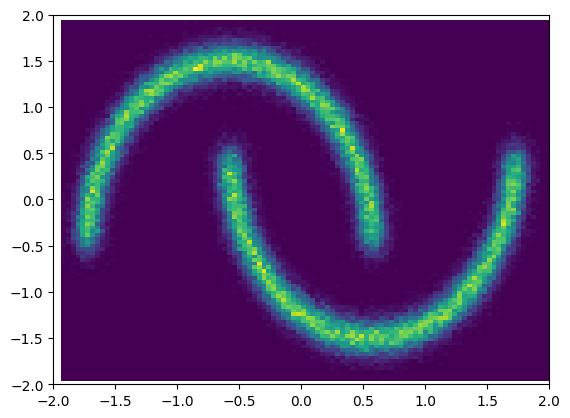

In [35]:
n_samples = 100_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

In [78]:
class MLP(nn.Module):
    """ A simple MLP in Flax. This is the score function.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 2

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

In [102]:
def beta_t(t, t_min=1e-4, t_max=0.02):
    """ Linear variance schedule
    """
    return t_min + (t_max - t_min) * t

def alpha_t(t, t_min=1e-4, t_max=0.02):
    """ Linear learning rate schedule
    """
    return 1 - beta_t(t, t_min, t_max)

def alpha_t_bar(t_n, t_N=100, t_min=1e-4, t_max=0.02):
    """ Linear learning rate schedule
    """
    alpha_t_ary = jax.vmap(alpha_t, in_axes=(0,None,None))(np.arange(t_N) / t_N, t_min, t_max)
    alpha_t_cumprod = np.cumprod(alpha_t_ary)
    return alpha_t_cumprod[t_n]


@partial(jax.jit, static_argnums=(3,))
def loss_fn(params, x, t_n, score, key):
    eps = jax.random.normal(key, shape=x.shape)
    alpha_t_bar_ary = jax.vmap(alpha_t_bar, in_axes=(0,None,None,None))(t_n, t_N, 1e-4, 0.02)
    x_t = np.sqrt(alpha_t_bar_ary) * x + np.sqrt(1 - alpha_t_bar_ary) * eps
    eps_pred = score.apply(params, np.concatenate([x_t, t_n / t_N], -1))    
    return np.mean((eps - eps_pred) ** 2)

key = jax.random.PRNGKey(0)
t_n = np.arange(100)[:, None]
t_N = 100

score = MLP(hidden_dim=128, out_dim=2, n_layers=5)
params = score.init(key, np.concatenate([x[:100], t_n / t_N], axis=1))

loss_fn(params, x[:100], t_n[:100], score, key)

Array(1.1208127, dtype=float32)

In [103]:
opt = optax.adamw(learning_rate=3e-4, weight_decay=1e-4)
opt_state = opt.init(params)

In [131]:
n_steps = 5_000
n_batch = 128
t_N = 100

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        t_n_batch = jax.random.choice(key, t_N, shape=(x_batch.shape[0], 1))

        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, t_n_batch, score, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 5000/5000 [00:41<00:00, 119.37it/s, val=0.47723198]


In [139]:
alpha_t_bar(59, 100)

Array(0.6979106, dtype=float32)

In [193]:
t_N_sampling = 5

def single_sample_fn(score, params, key):
    """ Ancestral sampling.
    """

    x_t = jax.random.normal(key, (2,))

    for t_i in range(t_N_sampling, 0, -1):

        t = (t_i / t_N_sampling)

        t = np.atleast_1d(t)
        
        key, _ = jax.random.split(key)
        eps = jax.random.normal(key, shape=x_t.shape) 
        eps_pred = score.apply(params, np.concatenate([x_t, t], axis=-1))

        # Often just sigma_t = beta_t is taken for simplicity
        sigma_t = np.sqrt((1 - alpha_t_bar(t_i - 1, t_N_sampling)) / (1 - alpha_t_bar(t_i, t_N_sampling)) * beta_t((t)))

        x_t = 1 / (np.sqrt(alpha_t(t))) * (x_t - (1 - alpha_t(t)) / (np.sqrt(1 - alpha_t_bar(t_i, t_N_sampling))) * eps_pred) + sigma_t * eps
        
    return x_t


key = jax.random.PRNGKey(42)

single_sample_fn(score, params, key)

Array([-1.6364907 ,  0.30146348], dtype=float32)

In [194]:
sample_fn = partial(single_sample_fn, score, params)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)


(-2.0, 2.0)

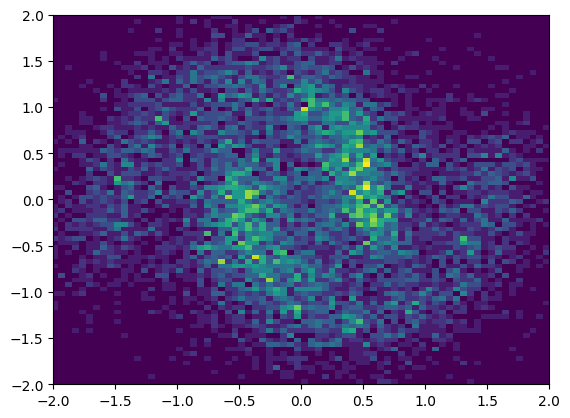

In [195]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

In [4]:
def int_beta(t):
    return t

def weight(t):
    return 1 - np.exp(-int_beta(t))

def alpha(t):
    return np.exp(-0.5 * int_beta(t))

def sigma(t):
    return np.sqrt(1 - np.exp(-int_beta(t)))

@partial(jax.jit, static_argnums=(3,4,))
def loss_fn(params, x, t, int_beta, score, key):
    eps = jax.random.normal(key, shape=x.shape)
    y = alpha(t) * x + sigma(t) * eps

    pred = score.apply(params, np.concatenate([y, t], -1))
    loss = weight(t) * np.mean((pred + eps / sigma(t)) ** 2)
    return loss.mean()

In [5]:
key = jax.random.PRNGKey(0)
t = np.ones((x.shape[0], 1))

score = MLP(hidden_dim=128, out_dim=2, n_layers=5)
params = score.init(key, np.concatenate([x, t], axis=1))

## Training

In [6]:
opt = optax.adamw(learning_rate=3e-4, weight_decay=1e-4)
opt_state = opt.init(params)

In [7]:
n_steps = 10_000
n_batch = 128
T = 1.

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        t_batch = jax.random.uniform(key, shape=(x_batch.shape[0], 1), minval=0., maxval=T)

        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, t_batch, int_beta, score, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 10000/10000 [01:23<00:00, 119.59it/s, val=4.5704923]


## Sampling

### Sampling via solving the (reverse-time) probability-flow ODE

In [8]:
def single_sample_fn(model, params, data_shape, dt0, t1, key):
    def drift(t, y, args):
        t = np.atleast_1d(t)
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))  # Get beta via autodiff
        return -0.5 * beta * (y + model.apply(params, np.concatenate([y, t], -1)))

    term = dfx.ODETerm(drift)
    solver = dfx.Euler()
    t0 = 0
    y1 = jax.random.normal(key, data_shape)
    # Reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

In [9]:
dt = 0.01

single_sample_fn(score, params, (2,), dt, T, key)

Array([-0.16437007,  1.4132596 ], dtype=float32, weak_type=True)

In [10]:
sample_fn = partial(single_sample_fn, score, params, (2,), dt, T)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)


(-2.0, 2.0)

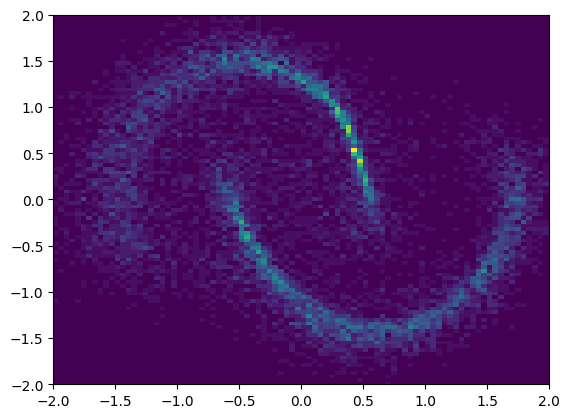

In [11]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

### Sampling via solving the reverse-time SDE

In [12]:

def single_sample_fn(model, params, data_shape, dt0, t1, key):

    def drift(t, y, args):
        t = np.atleast_1d(t)
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))  # Get beta via autodiff
        return -0.5 * beta * y - beta * model.apply(params, np.concatenate([y, t], -1))
    
    def diffusion(t, y, args):
        t = np.atleast_1d(t)
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))
        return np.sqrt(beta)

    t0 = 0

    bm = dfx.VirtualBrownianTree(t0, t1, tol=1e-5, shape=(1,), key=key)

    key, _ = jax.random.split(key)

    terms = dfx.MultiTerm(dfx.ODETerm(drift), dfx.ControlTerm(diffusion, bm))

    solver = dfx.Heun()

    y1 = jax.random.normal(key, data_shape)

    sol = dfx.diffeqsolve(terms, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

In [13]:
dt = 0.01

single_sample_fn(score, params, (2,), dt, T, key)

Array([ 1.406716, -0.880477], dtype=float32, weak_type=True)

In [14]:
sample_fn = partial(single_sample_fn, score, params, (2,), dt, T)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)

(-2.0, 2.0)

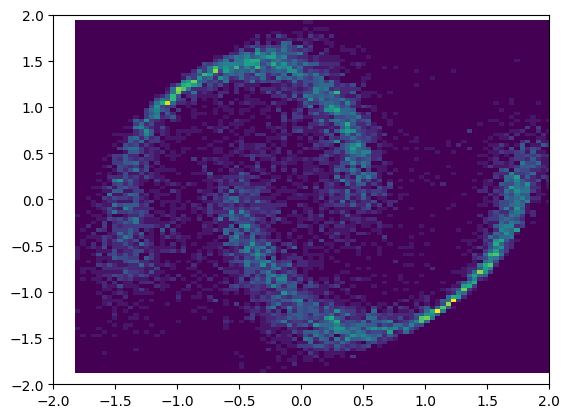

In [15]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

### Sampling via manual implementation of Euler

$$x_{t - \Delta t} = x_t - [f(x,t) - g(t)^2 s_\theta(x_t,t)]\Delta t + g(t)\sqrt{\Delta t} z_t$$

TODO: Implement DDIM update rule (see 2202.00512).

In [16]:
def single_sample_fn(model, params, dt0, t1, key):

    t = t1
    xT = jax.random.normal(key, (2,))

    for _ in range(n_steps):
        
        key, _ = jax.random.split(key)

        t = np.atleast_1d(t)
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))

        a = -0.5 * beta * xT - beta * model.apply(params, np.concatenate([xT, t], -1))
        b = np.sqrt(beta)

        xT = xT - a * dt0 + b * np.sqrt(dt0) * jax.random.normal(key, xT.shape)
        t -= dt0

    return xT

n_steps = 100
dt = T / n_steps

key = jax.random.PRNGKey(42)

single_sample_fn(score, params, dt, T, key)

Array([-1.5398089,  0.3553307], dtype=float32)

In [17]:
sample_fn = partial(single_sample_fn, score, params, dt, T)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)

x_sample = jax.vmap(sample_fn)(sample_key)

(-2.0, 2.0)

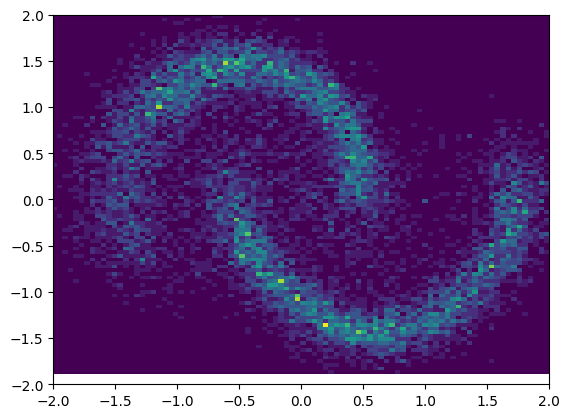

In [18]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)